<a href="https://www.kaggle.com/code/huseyincosgun/missing-data-imputation-visualization?scriptVersionId=140786678" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## <b><span style='color:#F1C40F'>1 |</span> Simple and advanced imputation; drop, mode, median, KNN, MICE</b>

Dealing with missing data is a prevalent and inherent challenge in data collection, particularly when dealing with extensive datasets. Numerous factors contribute to missing data, including participants providing incomplete information, non-responses from individuals who decide not to share data, poorly designed survey instruments, or the necessity to exclude data due to confidentiality concerns.

Types of Missing Data
When assessing the potential impact of missing data on registry findings, it is important to consider the underlying reasons for missing data. Missing data is grouped into three categories:
Missing completely at random (MCAR)
Missing at random (MAR)
Not missing at random (NMAR)

But we will continue without explanation on this section, let's continue to focus on the application part. Let's leave a useful [link](http://www.ncbi.nlm.nih.gov/books/NBK493614/).

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/diabetes-data-set/diabetes.csv
/kaggle/input/pima-indians-diabetes-database/diabetes.csv
/kaggle/input/pimaindiansdiabetescsv/pima-indians-diabetes.csv


In [2]:
def load():
    data = pd.read_csv("/kaggle/input/pima-indians-diabetes-database/diabetes.csv")
    return data

df = load()
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [3]:
df.rename(columns ={"DiabetesPedigreeFunction":"DPF"},inplace=True)

In [4]:
df.describe([0.01, 0.05, 0.75, 0.90, 0.99]).T

,count,mean,std,min,1%,5%,50%,75%,90%,99%,max
Pregnancies,768.000,3.845,3.370,0.000,0.000,0.000,3.000,6.000,9.000,13.000,17.000
Glucose,768.000,120.895,31.973,0.000,57.000,79.000,117.000,140.250,167.000,196.000,199.000
BloodPressure,768.000,69.105,19.356,0.000,0.000,38.700,72.000,80.000,88.000,106.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,0.000,23.000,32.000,40.000,51.330,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,0.000,30.500,127.250,210.000,519.900,846.000
BMI,768.000,31.993,7.884,0.000,0.000,21.800,32.000,36.600,41.500,50.759,67.100
DPF,768.000,0.472,0.331,0.078,0.095,0.140,0.372,0.626,0.879,1.698,2.420
Age,768.000,33.241,11.760,21.000,21.000,21.000,29.000,41.000,51.000,67.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000


In [5]:
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
0,6,148.000,72.000,35.000,NaN,33.600,0.627,50,1
1,1,85.000,66.000,29.000,NaN,26.600,0.351,31,0
2,8,183.000,64.000,NaN,NaN,23.300,0.672,32,1
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1


In [6]:
# Define missing plot to detect all missing values in dataset
def missing_plot(dataset, key) :
    null_feat = pd.DataFrame(len(dataset[key]) - dataset.isnull().sum(), columns = ['Count'])
    percentage_null = pd.DataFrame((len(dataset[key]) - (len(dataset[key]) - dataset.isnull().sum()))/len(dataset[key])*100, columns = ['Count'])
    percentage_null = percentage_null.round(2)

    trace = go.Bar(x = null_feat.index, y = null_feat['Count'] ,opacity = 0.8, text = percentage_null['Count'],  textposition = 'auto',marker=dict(color = '#7EC0EE',
            line=dict(color='#000000',width=1.5)))

    layout = dict(title =  "Missing Values (count & %)")

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)

In [7]:
# Plotting 
missing_plot(df, 'Outcome')

In [8]:
def missing_percent(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_table = pd.concat([mis_val, mis_percent], axis=1)
        
        # Rename the columns
        mis_columns = mis_table.rename(
        columns = {0 : 'Missing Values', 1 : 'Percent of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_columns = mis_columns[
            mis_columns.iloc[:,1] != 0].sort_values(
        'Percent of Total Values', ascending=False).round(2)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_columns

In [9]:
miss_cols_info = missing_percent(df)
miss_cols_info

Your selected dataframe has 9 columns.
There are 5 columns that have missing values.


,Missing Values,Percent of Total Values
Insulin,374,48.700
SkinThickness,227,29.560
BloodPressure,35,4.560
BMI,11,1.430
Glucose,5,0.650


<div style="color:white;display:fill;border-radius:8px;
            background-color:#2C3E50 ;font-size:110%;
            font-family:Helvetica;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>1) Drop Missing Data</b></p>
</div>

<div style="color:white;display:fill;border-radius:8px;
            background-color:#2C3E50 ;font-size:110%;
            font-family:Helvetica;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>1.1)Dropping columns with nan values</b></p>
</div>

Columns with a missing values of more than 70% are dropped and the analysis continues. However, this rate in our data set does not exceed 50%.

We may want to apply different operations according to the proportions of missing values in the data set. In our example, we want to drop the independent variables that have more than 25% missing values.

In [10]:
df_drop = df.copy()
df_drop.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
0,6,148.000,72.000,35.000,NaN,33.600,0.627,50,1
1,1,85.000,66.000,29.000,NaN,26.600,0.351,31,0
2,8,183.000,64.000,NaN,NaN,23.300,0.672,32,1
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1


In [11]:
#Columns with more than 25% missing data
drop_cols = miss_cols_info[miss_cols_info['Percent of Total Values'] > 25]
drop_cols 

,Missing Values,Percent of Total Values
Insulin,374,48.700
SkinThickness,227,29.560


In [12]:
col_names = drop_cols.index.tolist()
col_names

['Insulin', 'SkinThickness']

In [13]:
# Deleted 2 columns containing nan: ['Insulin', 'SkinThickness']
df_drop.drop(col_names, axis = 1, inplace=True)
df_drop.head()

,Pregnancies,Glucose,BloodPressure,BMI,DPF,Age,Outcome
0,6,148.000,72.000,33.600,0.627,50,1
1,1,85.000,66.000,26.600,0.351,31,0
2,8,183.000,64.000,23.300,0.672,32,1
3,1,89.000,66.000,28.100,0.167,21,0
4,0,137.000,40.000,43.100,2.288,33,1


<div style="color:white;display:fill;border-radius:8px;
            background-color:#2C3E50 ;font-size:110%;
            font-family:Helvetica;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>1.2) Dropping rows with nan values</b></p>
</div>

In [14]:
# Now deleted rows 2 columns containing nan for ['Insulin', 'SkinThickness']
df_drop_rows = df.copy()
df_drop_rows.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
0,6,148.000,72.000,35.000,NaN,33.600,0.627,50,1
1,1,85.000,66.000,29.000,NaN,26.600,0.351,31,0
2,8,183.000,64.000,NaN,NaN,23.300,0.672,32,1
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1


In [15]:
df_drop_rows=df_drop_rows.dropna(subset=col_names)
df_drop_rows.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1
6,3,78.000,50.000,32.000,88.000,31.000,0.248,26,1
8,2,197.000,70.000,45.000,543.000,30.500,0.158,53,1
13,1,189.000,60.000,23.000,846.000,30.100,0.398,59,1


/tmp/ipykernel_22/3744694985.py:2: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



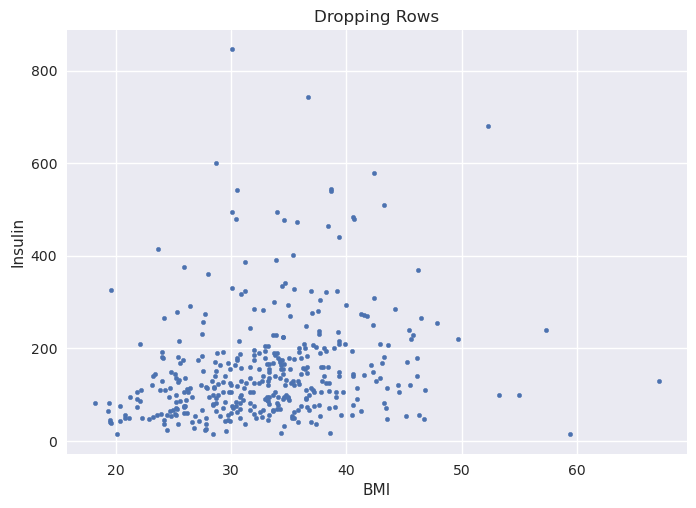

In [16]:
# Analyze visually with scatter plot
plt.style.use('seaborn')
fig = plt.Figure()
fig = df_drop_rows.plot(x="BMI", y='Insulin', kind='scatter',
                    s = 10,
                    title='Dropping Rows', colorbar=False)

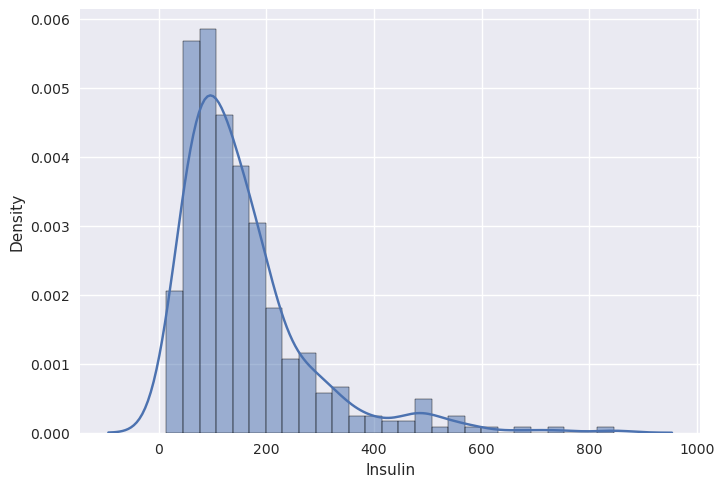

In [17]:
sns.histplot(
    df_drop_rows["Insulin"], kde=True,
    stat="density", kde_kws=dict(cut=3)
)
sns.set_style("darkgrid")

<div style="color:white;display:fill;border-radius:8px;
            background-color:#2C3E50 ;font-size:110%;
            font-family:Helvetica;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>2) Simple Imputation Methods</b></p>
</div>

The scikit-learn library provides a useful tool called the SimpleImputer function for addressing missing values in datasets. This function allows us to replace these missing values with a specified fill value. Within the SimpleImputer function, there exists a parameter known as strategy. This parameter offers four different options(mean(default), median, most_frequent and constant), each representing a distinct imputation method.


<div style="color:white;display:fill;border-radius:8px;
            background-color:#2C3E50 ;font-size:110%;
            font-family:Helvetica;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>2.1) Mean İmputation</b></p>
</div>



In [18]:
df_mean = df.copy()

In [19]:
round(df_mean['Insulin'].mean(), 2)

155.55

In [20]:
mean_imputer = SimpleImputer(missing_values = np.nan,strategy ='mean')
df_mean['Insulin'] = mean_imputer.fit_transform(
    df_mean['Insulin'].values.reshape(-1,1))

/tmp/ipykernel_22/2520735425.py:2: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



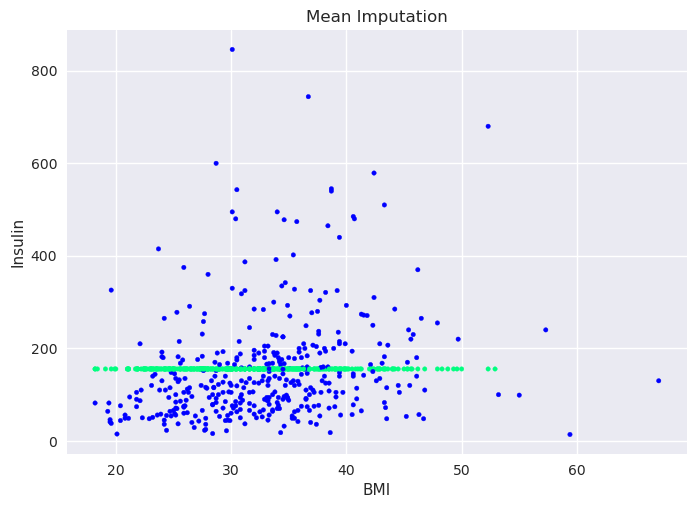

In [21]:
# Analyze visually with scatter plot
plt.style.use('seaborn')
fig = plt.Figure()
null_values = df['Insulin'].isnull()
fig = df_mean.plot(x="BMI", y='Insulin', kind='scatter',
                     c=null_values, cmap='winter',s = 10,
                     title='Mean Imputation', colorbar=False)

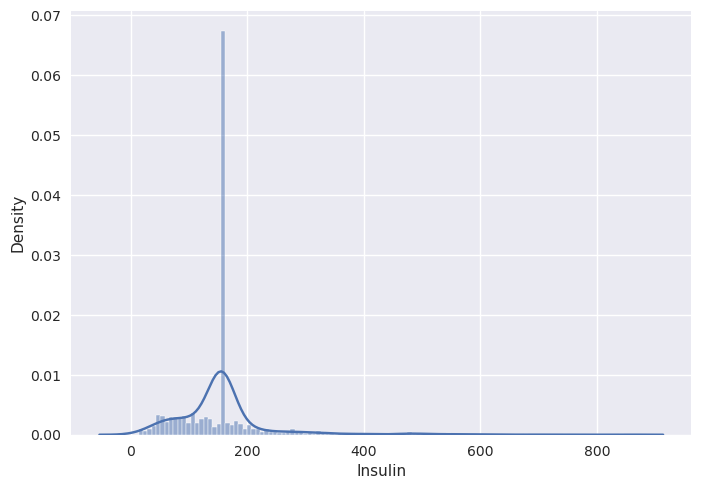

In [22]:
sns.histplot(
    df_mean["Insulin"], kde=True,
    stat="density", kde_kws=dict(cut=3)
)
sns.set_style("darkgrid")

<div style="color:white;display:fill;border-radius:8px;
            background-color:#2C3E50 ;font-size:110%;
            font-family:Helvetica;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>2.2) Median İmputation</b></p>
</div>

In [23]:
df_median = df.copy()

In [24]:
round(df_median['Insulin'].median(), 2)

125.0

In [25]:
#Median Imputation
median_imputer = SimpleImputer(missing_values = np.nan,
                        strategy ='median')
df_median['Insulin'] = median_imputer.fit_transform(
    df_median['Insulin'].values.reshape(-1,1))

/tmp/ipykernel_22/3710990269.py:2: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



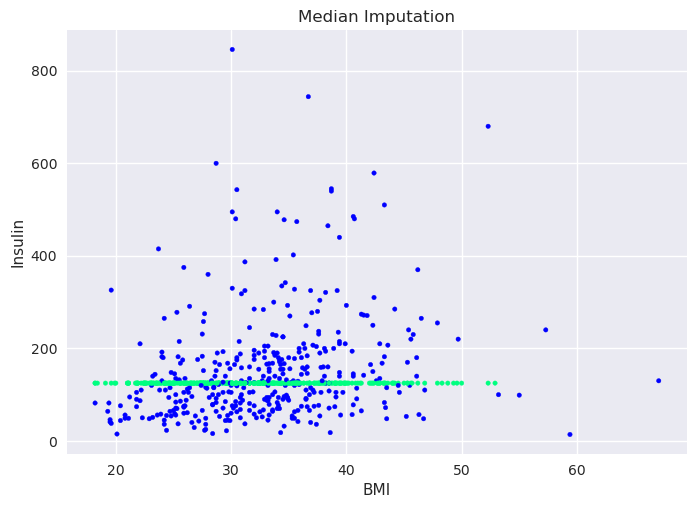

In [26]:
# Analyze visually with scatter plot
plt.style.use('seaborn')
fig = plt.Figure()
null_values = df['Insulin'].isnull()
fig = df_median.plot(x="BMI", y='Insulin', kind='scatter', 
                     c=null_values, cmap='winter',s = 10, 
                     title='Median Imputation', colorbar=False)

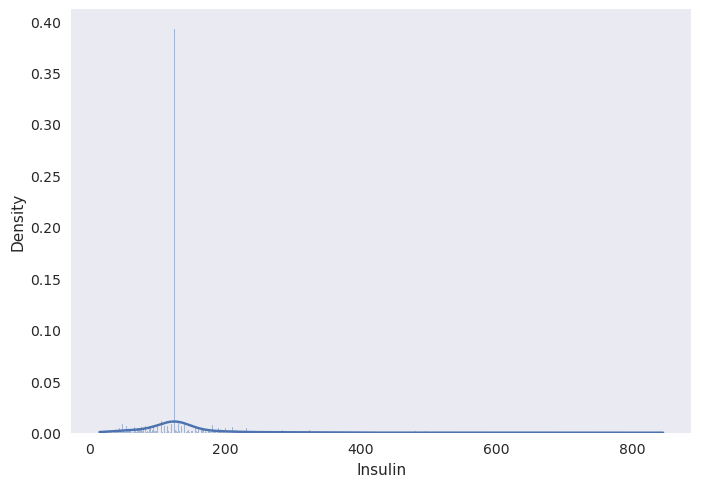

In [27]:
sns.histplot(
    df_median["Insulin"], kde=True,
    stat="density")
plt.grid()
sns.set_style("darkgrid")

Most of the imputation technique can cause bias. Simple imputation can result in an underestimation of standard errors. Simple imputed data for any statistic can lead to an underestimation of the standard error. As the number of missing data increases, simple imputation methods should be avoided.

<div style="color:white;display:fill;border-radius:8px;
            background-color:#2C3E50 ;font-size:110%;
            font-family:Helvetica;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>3) Advanced Imputation Methods</b></p>
</div>

One commonly adopted strategy for addressing missing data is to employ a predictive model to estimate the absent values. This technique entails developing a separate model for each input variable containing missing entries.

<div style="color:white;display:fill;border-radius:8px;
            background-color:#2C3E50 ;font-size:110%;
            font-family:Helvetica;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>3.1) K-Nearest Neighbour (KNN) Imputation</b></p>
</div>

The default value of K is set to 5. Although there is no definitive method for determining the ideal value of K, a commonly used heuristic suggests that the optimal K is often the square root of the total number of samples in the dataset. Typically, an odd value is chosen for K to prevent ties in decision-making. To identify the most suitable K, an error plot or accuracy plot is commonly used.

In [28]:
df_knn = df.copy()

In [29]:
df_knn.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
0,6,148.000,72.000,35.000,NaN,33.600,0.627,50,1
1,1,85.000,66.000,29.000,NaN,26.600,0.351,31,0
2,8,183.000,64.000,NaN,NaN,23.300,0.672,32,1
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1


In [30]:
df_knn = df_knn.filter(['Pregnancies','Glucose','BloodPressure','BMI','DPF','Age','Insulin'], axis=1).copy()
df_knn.head()

,Pregnancies,Glucose,BloodPressure,BMI,DPF,Age,Insulin
0,6,148.000,72.000,33.600,0.627,50,NaN
1,1,85.000,66.000,26.600,0.351,31,NaN
2,8,183.000,64.000,23.300,0.672,32,NaN
3,1,89.000,66.000,28.100,0.167,21,94.000
4,0,137.000,40.000,43.100,2.288,33,168.000


In [31]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_knn = pd.DataFrame(scaler.fit_transform(df_knn), columns = df_knn.columns)

# Define KNN imputer and fill missing values
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
df_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(df_knn), columns=df_knn.columns)

In [32]:
df_knn_imputed.head()

,Pregnancies,Glucose,BloodPressure,BMI,DPF,Age,Insulin
0,0.353,0.671,0.490,0.315,0.234,0.483,0.287
1,0.059,0.265,0.429,0.172,0.117,0.167,0.045
2,0.471,0.897,0.408,0.104,0.254,0.183,0.275
3,0.059,0.290,0.429,0.202,0.038,0.000,0.096
4,0.000,0.600,0.163,0.509,0.944,0.200,0.185


In [33]:
original_data = scaler.inverse_transform(df_knn_imputed)
# Convert the original data to a DataFrame
df_original = pd.DataFrame(original_data, columns=df_knn.columns)

In [34]:
df_original.head()

,Pregnancies,Glucose,BloodPressure,BMI,DPF,Age,Insulin
0,6.000,148.000,72.000,33.600,0.627,50.000,253.200
1,1.000,85.000,66.000,26.600,0.351,31.000,51.600
2,8.000,183.000,64.000,23.300,0.672,32.000,243.000
3,1.000,89.000,66.000,28.100,0.167,21.000,94.000
4,0.000,137.000,40.000,43.100,2.288,33.000,168.000


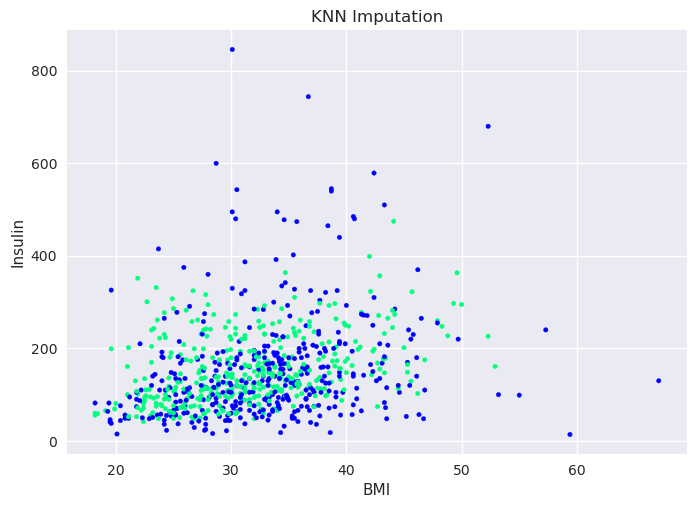

In [35]:
fig = plt.Figure()
null_values = df['Insulin'].isnull() 
fig = df_original.plot(x='BMI', y='Insulin', kind='scatter',
                          c=null_values, cmap='winter', s = 10,
                          title='KNN Imputation', colorbar=False)

Text(0.5, 1.0, 'KNN Imputation')

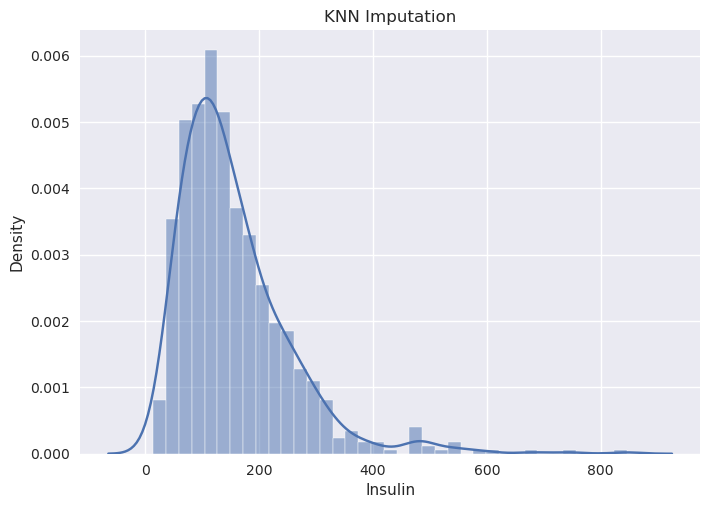

In [36]:
sns.histplot(
    df_original["Insulin"], kde=True,
    stat="density", kde_kws=dict(cut=3)
)
plt.title('KNN Imputation')

K-Nearest Neighbors (KNN) imputation tends to incur higher computational costs compared to simple imputation methods. However, it's important to note that KNN imputation remains effective for datasets that do not exceed the scale of tens of millions of records. However, as we can see from the scatterplots, knn seems to have completed the missing values in a way that does not distort a normal distribution.

<div style="color:white;display:fill;border-radius:8px;
            background-color:#2C3E50 ;font-size:110%;
            font-family:Helvetica;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>3.2 Multivariate Imputation by Chained Equation - MICE</b></p>
</div>

MICE Imputation, short for 'Multiple Imputation by Chained Equation' is an advanced missing data imputation technique that uses multiple iterations of Machine Learning model training to predict the missing values using known values from other features in the data as predictors.

#### How does MICE algorithm work?
Here is a quick intuition (not the exact algorithm)
1. You basically take the variable that contains missing values as a response 'Y' and other variables as predictors 'X'.
2. Build a model with rows where Y is not missing.
3. Then predict the missing observations.
Do this multiple times by doing random draws of the data and taking the mean of the predictions.

In [37]:
df_mice = df.copy()
df_mice.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
0,6,148.000,72.000,35.000,NaN,33.600,0.627,50,1
1,1,85.000,66.000,29.000,NaN,26.600,0.351,31,0
2,8,183.000,64.000,NaN,NaN,23.300,0.672,32,1
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1


In [38]:
df_mice = df.filter(['Pregnancies','Glucose','BloodPressure','BMI','DPF','Age','Insulin'], axis=1).copy()

# Define MICE Imputer and fill missing values
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')
df_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(df_mice), columns=df_mice.columns)

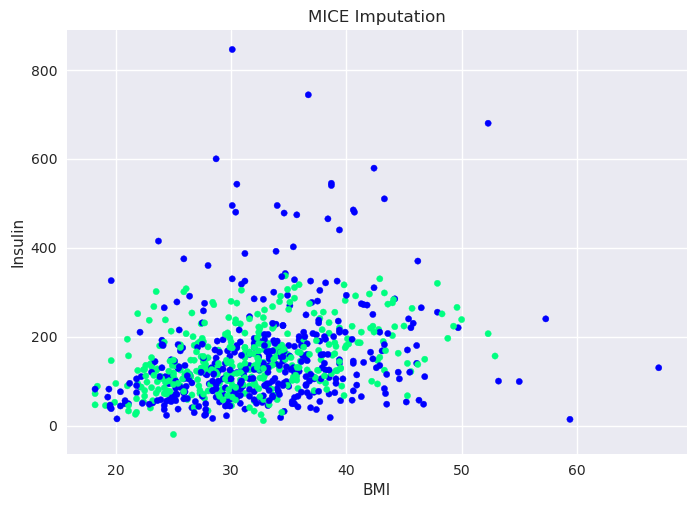

In [39]:
fig = plt.Figure()
null_values = df['Insulin'].isnull() 
fig = df_mice_imputed.plot(x='BMI', y='Insulin', kind='scatter', c=null_values, cmap='winter', title='MICE Imputation', colorbar=False)

Text(0.5, 1.0, 'MICE Imputation')

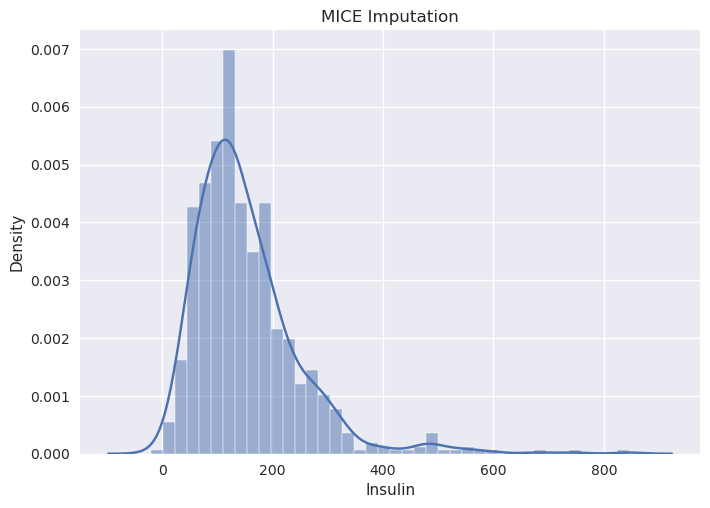

In [40]:
sns.histplot(
    df_mice_imputed["Insulin"], kde=True,
    stat="density", kde_kws=dict(cut=3)
)
plt.title('MICE Imputation')

<div style="color:white;display:fill;border-radius:8px;
            background-color:#2C3E50 ;font-size:110%;
            font-family:Helvetica;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b> Compare All Imputation </b></p>
</div>

In [41]:
# df_drop_rows["Insulin"]
# df_mean["Insulin"]
# df_median["Insulin"]
# df_original["Insulin"] (KNN)
# df_mice_imputed["Insulin"]

In [42]:
drop_rows = pd.Series(df_drop_rows["Insulin"], name='drop_rows')
df_mean_ins = pd.Series(df_mean["Insulin"], name='Mean_Imp')
df_median_ins = pd.Series(df_median["Insulin"], name='Median_Imp')
df_knn_ins = pd.Series(df_original["Insulin"], name='KNN_Imp')
df_mice_ins = pd.Series(df_mice_imputed["Insulin"], name='MICE_Imp')

In [43]:
df_all = pd.concat([df_mean_ins,df_median_ins,df_knn_ins,df_mice_ins],axis=1)

In [44]:
df_all.head()

,Mean_Imp,Median_Imp,KNN_Imp,MICE_Imp
0,155.548,125.000,253.200,218.789
1,155.548,125.000,51.600,68.766
2,155.548,125.000,243.000,267.615
3,94.000,94.000,94.000,94.000
4,168.000,168.000,168.000,168.000


In [45]:
df_dropped = drop_rows.to_frame()
df_dropped.describe().T

,count,mean,std,min,25%,50%,75%,max
drop_rows,394.000,155.548,118.776,14.000,76.250,125.000,190.000,846.000


In [46]:
df_all.describe().T

,count,mean,std,min,25%,50%,75%,max
Mean_Imp,768.000,155.548,85.021,14.000,121.500,155.548,155.548,846.000
Median_Imp,768.000,140.672,86.383,14.000,121.500,125.000,127.250,846.000
KNN_Imp,768.000,155.905,99.482,14.000,90.000,132.600,195.400,846.000
MICE_Imp,768.000,152.565,97.432,-20.077,89.468,130.000,189.287,846.000


### Conclusion

In this article, we analyze the results by applying different methods on how to deal with missing data. In the first stage, we identified missing data and analyzed the density in the data set visually and proportionally. We continued by coding how to deal with the detected missing data. 

First, we analyzed the results using dropping and simple imputation methods. Mean and median imputation for a variable with a high proportion of missing data gives biased results. Or it distorts the correlation with other variables. But we chose to go a little deeper and collaborate with other variables in the dataset. In this way, we realized that instead of considering variables separately from the dataset, it is more accurate to solve this problem by considering all variables together.

Among the advanced imputation methods, we used KNN and MICE to fill in the missing data. The result gave a fairly accurate distribution compared to simple techniques.

**Kaggle**: https://www.kaggle.com/huseyincosgun

**Linkedin**: https://www.linkedin.com/in/hasanhuseyincosgun/

***References***

https://www.scirp.org/journal/paperinformation.aspx?paperid=112455

https://towardsdatascience.com/imputing-missing-data-with-simple-and-advanced-techniques-f5c7b157fb87

https://towardsdatascience.com/getting-acquainted-with-k-nearest-neighbors-ba0a9ecf354f

https://www.machinelearningplus.com/machine-learning/mice-imputation/#:~:text=MICE%20Imputation,%20short%20for%20'Multiple,in%20the%20data%20as%20predictors

https://www.ncbi.nlm.nih.gov/books/NBK493614/